In [36]:
#############
# LIBRARIES #
#############

# libraries to interact with the operating system 
import os
import sys
import glob
import h5py
# libraries for data structuration and calculations
import pandas as pd  # to create data frames
import numpy as np   # most important numerical calculations
# to read in mat files
import readmat
# needed to extract the run number out of the parentesis of the string in the SPM.mat file
import re
# library for neuroimaging
import nibabel as nib
# machine learning algorithms and stuff
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score, PredefinedSplit, permutation_test_score
# to check and optimize time performance
import time
import multiprocessing
# plotting
import matplotlib.pyplot as plt

In [37]:
# variables for permutation testing
rng_seed = 1

# Number of permutations
n_permutations = 10

# Number of CPUs
max_num_CPU = 24                          # do not use more than that
num_CPU = multiprocessing.cpu_count()     # get number of cores
# TODO: improve
n_proc = min([num_CPU,max_num_CPU])       # set the number of cores that should be used

In [10]:
targets = np.asarray(label_df.Labels)
chunks = np.asarray(label_df.Chunks)
if n_permutations > 0:
    res = permutation_test_score(
        LDA(solver='lsqr', shrinkage='auto'),
        betas,
        targets,
        groups=chunks,
        cv=PredefinedSplit(chunks),
        n_permutations=n_permutations,
        random_state=rng_seed,
        n_jobs=n_proc,
        verbose=3)
    accuracy = res[0]
    null_distribution = res[1]
    p_value = res[2]

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    4.0s remaining:    9.2s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    4.0s remaining:    1.7s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    4.6s finished


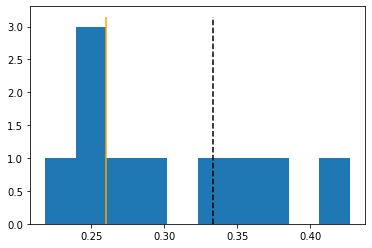

In [11]:
if n_permutations > 0:
    plt.hist(null_distribution)
    y_min, y_max = plt.ylim()
    plt.vlines(1/len(label_names), y_min, y_max, color='k', linestyles='--')
    plt.vlines(accuracy, y_min, y_max, color='orange')

In [23]:
results_dir = '/Users/vpl/Documents/Master_Thesis/DATA/BIDS_playground/derivatives/sklearn-decoding/sub-01/ROIs'
if not os.path.isdir(results_dir):
    os.makedirs(results_dir)


In [31]:
label_df['Chunks'] = (label_df.Runs-1)//2   # The chunks (needed for cross validation)

In [38]:
output_dir

'/Users/vpl/Documents/Master_Thesis/DATA/BIDS_playground/derivatives/sklearn-decoding/sub-01/ROI-analysis/hV4'

In [38]:
t_start = time.time()

# what kind of analysis
analysis = 'ROI-analysis'

# define ROIs
ROIs = ['hV4', 'LO', 'FEF']
# label names which are used to select the labels
label_names = [
    'Appear',
    'Change',
    'Vanish'
] 

# declare all path names
data_dir = '/Users/vpl/Documents/Master_Thesis/DATA/BIDS_playground/derivatives/spm12-glm'     # directory where to look for subjects
GLM_name = 'TrickVersionSpecialMoment/'             # Which GLM created the beta images we are going to use
GLM_dir = os.path.join(data_dir, GLM_name,'sub-*')  # combine the Path
surfer_dir = '/Users/vpl/Documents/Master_Thesis/DATA/BIDS_playground/derivatives/surfer/'     # the freesurfer directory
subjects = glob.glob(GLM_dir)                # 
results_dir = '/Users/vpl/Documents/Master_Thesis/DATA/BIDS_playground/derivatives/sklearn-decoding'
if not os.path.isdir(results_dir):
    os.mkdir(results_dir)

# outer loop - iterating over subjects
for s,sub in enumerate(subjects):
    ##########################
    # subject specific paths #
    ##########################
    
    # SPM.mat file direcory. Used to get the names of the regressors and the corresponding beta maps
    SPM_mat_dir = os.path.join(sub, 'SPM.mat')
    # directory where to look for the ROIs
    ROI_dir = os.path.join(surfer_dir,'sub-%02i' %(s+1),'ROIs')
    # subject specific directory for results
    sub_results_dir = os.path.join(results_dir, 'sub-%02i' %(s+1), analysis)
    if not os.path.isdir(sub_results_dir):
        os.makedirs(sub_results_dir)
    
    ########################################
    # reading in the necessary information #
    ########################################
    
    # From the previously created SPM.mat file we read in information we need
    # The filenames of our beta images
    SPM_betadict = readmat.load(SPM_mat_dir, isStruct=True)['SPM']['Vbeta']
    beta_dirs = [f['fname'] for f in SPM_betadict]
    # The corresponding Regressor names - are in form of 'Sn(<run-number>) <Regressor-Name>*bf(1)'
    SPM_regressors = readmat.load(SPM_mat_dir,isStruct=True)['SPM']['xX']['name']

    # store beta filenames and regressornames in a dictionary
    data_dict = {
        'Regressors': SPM_regressors,
        'BetaNames': beta_dirs
    }

    # convert dictionary into a pandas DataFrame for further analysis
    label_df = pd.DataFrame(data_dict, columns=data_dict.keys())

    # This complex loop is necessary to get the run number out of the regressor name
    x = [' '.join(re.findall(r"\((\d+)\)",string)) for string in label_df.Regressors]
    runs = [int(s_filter.split()[0]) for s_filter in x]
    # add further data to DataFrame
    label_df['Runs'] = runs                     # In which run
    label_df['Chunks'] = (label_df.Runs-1)//2   # The chunks (needed for cross validation)
    label_df['Labels'] = np.nan                 # Labels
    # Check for every entry in Regressors if it contains one of the label names. If so, assign the label name
    for l in label_names:
        label_df.Labels[label_df.Regressors.str.contains(l)] = l

    # again a complex process to throw out regressors of no interest (like realignment)
    regressors_of_interest = [True if any(i in n for i in label_names) else False for n in SPM_regressors]
    # throw out all rows of regressors of no interest
    label_df = label_df.iloc[regressors_of_interest]
    
    # inner loop - iterating over mask (=ROIs)
    for r, roi in enumerate(ROIs):
        output_dir = os.path.join(sub_results_dir,roi)   # where to store the results
        #if not os.path.isdir(output_dir):
        #    os.mkdir(output_dir)
        
        # call combineROIs with the selected ROI and ROI directory
        #ROI = combineROIs(roi, ROI_dir)
        maskdir_list = glob.glob(os.path.join(ROI_dir,'*' + roi + '*.nii'))
        masklist = []
        for mask in maskdir_list:
            mask_nii = nib.load(mask)
            mask_img = mask_nii.get_fdata()
            mask_img = np.asarray(mask_img)
            mask_img = mask_img.flatten()
            masklist.append(mask_img)
            
        ROI = np.sum(masklist,axis=0)
        ROI = ROI>0
        # read in all beta image files, convert them into a one-dimensional numpy array and select the entries of ROI
        betas = []                                              # empty list to store data arrays in
        for b, beta in enumerate(label_df.BetaNames):
            beta_nii = nib.load(os.path.join(subject_dir,beta)) # read in beta NIfTI image
            beta_data = beta_nii.get_fdata()                    # get data from NIfTI image
            beta_data = beta_data.flatten()                     # convert into one-dimensional array
            beta_data = beta_data[ROI]                          # select entries from ROI
            beta_data = beta_data[~np.isnan(beta_data)]         # throw out all NaN values. This can happen, when the mask selects Voxels that are on the skull or skin
            betas.append(beta_data)                             # append array on betas list

        # convert list into numpy array 
        betas = np.array(betas)
        
        # the actual decoding
        targets = np.asarray(label_df.Labels)
        chunks = np.asarray(label_df.Chunks)
        if n_permutations > 0:
            res = permutation_test_score(
                LDA(solver='lsqr', shrinkage='auto'),
                betas,
                targets,
                groups=chunks,
                cv=PredefinedSplit(chunks),
                n_permutations=n_permutations,
                random_state=rng_seed,
                n_jobs=n_proc,
                verbose=3)
            accuracy = res[0]
            null_distribution = res[1]
            p_value = res[2]
        
        t_hrs_delta = (time.time() - t_start) / 3600.
        
        with h5py.File(output_dir, 'w') as f:
            f.create_dataset('t_hrs_delta', data=t_hrs_delta)
            f.create_dataset('accuracy', data=accuracy)
            if n_permutations > 0:
                f.create_dataset('null_distribution', data=null_distribution)
                f.create_dataset('p_value', data=p_value)
                
    del label_df
    del betas

/Users/vpl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    5.4s remaining:   12.5s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    5.4s remaining:    2.3s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    6.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    7.8s remaining:   18.3s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    7.9s remaining:    3.4s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    9.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

In [2]:
################################################################################################
# TEST FIELD TO DECODE ONLY ONE DECODER ON ONE SUBJECT AND ONE ROI - LATER TO BE USED IN LOOPS #
################################################################################################

# declare all path names
data_dir = '/Users/vpl/Documents/Master_Thesis/DATA/BIDS_playground/derivatives/spm12-glm'     # directory where to look for subjects
GLM_name = 'TrickVersionSpecialMoment'       # Which GLM created the beta images we are going to use
GLM_dir = os.path.join(data_dir, GLM_name)   # combine the Path
surfer_dir = '/Users/vpl/Documents/Master_Thesis/DATA/BIDS_playground/derivatives/surfer/'     # the freesurfer directory
subject_name = 'sub-%02i' %1                        # subject one
subject_dir = os.path.join(GLM_dir, subject_name)   # subject directory
SPM_mat_dir = os.path.join(subject_dir , 'SPM.mat') # SPM.mat file direcory. Used to get the names of the regressors and the corresponding beta maps
ROI_dir = os.path.join(surfer_dir,subject_name,'ROIs')

# The ROI to use
ROI_name = 'LO'
nifti_list = glob.glob(os.path.join(ROI_dir,'*' + '.' + ROI_name + '*.nii'))

In [33]:
l1 = []
for nii in nifti_list:
    img = nib.load(nii)
    img = img.get_fdata()
    img = np.asarray(img,dtype=bool)
    img = img.flatten()
    l1.append(img)
    
l2 = np.sum(l1,axis=0)
overlap = l2>1
l2 = l2>0

In [5]:
################################################################################################
# TEST FIELD TO DECODE ONLY ONE DECODER ON ONE SUBJECT AND ONE ROI - LATER TO BE USED IN LOOPS #
################################################################################################

# declare all path names
data_dir = '/Users/vpl/Documents/Master_Thesis/DATA/BIDS_playground/derivatives/spm12-glm'     # directory where to look for subjects
GLM_name = 'TrickVersionSpecialMoment'       # Which GLM created the beta images we are going to use
GLM_dir = os.path.join(data_dir, GLM_name)   # combine the Path
surfer_dir = '/Users/vpl/Documents/Master_Thesis/DATA/BIDS_playground/derivatives/surfer/'     # the freesurfer directory
subject_name = 'sub-%02i' %1                        # subject one
subject_dir = os.path.join(GLM_dir, subject_name)   # subject directory
SPM_mat_dir = os.path.join(subject_dir , 'SPM.mat') # SPM.mat file direcory. Used to get the names of the regressors and the corresponding beta maps
ROI_dir = os.path.join(surfer_dir,subject_name,'ROIs')

# The ROI to use
ROI_name = 'LO1'

# call combineROIs with the selected ROI and ROI directory
ROI = combineROIs(ROI_name, ROI_dir)

# label names which are used to select the labels
label_names = [
    'Appear',
    'Change',
    'Vanish'
] 

# From the previously created SPM.mat file we read in information we need
# The filenames of our beta images
SPM_betadict = readmat.load(SPM_mat_dir, isStruct=True)['SPM']['Vbeta']
betas = [f['fname'] for f in SPM_betadict]
# The corresponding Regressor names - are in form of 'Sn(<run-number>) <Regressor-Name>*bf(1)'
SPM_regressors = readmat.load(SPM_mat_dir,isStruct=True)['SPM']['xX']['name']

# store beta filenames and regressornames in a dictionary
data_dict = {
    'Regressors': SPM_regressors,
    'BetaNames': betas
}

# convert dictionary into a pandas DataFrame for further analysis
label_df = pd.DataFrame(data_dict, columns=data_dict.keys())

# This complex loop is necessary to get the run number out of the regressor name
x = [' '.join(re.findall(r"\((\d+)\)",string)) for string in label_df.Regressors]
runs = [int(s_filter.split()[0]) for s_filter in x]
# add further data to DataFrame
label_df['Runs'] = runs                 # In which run
label_df['Chunks'] = label_df.Runs//2   # The chunks (needed for cross validation)
label_df['Labels'] = np.nan             # Labels
# Check for every entry in Regressors if it contains one of the label names. If so, assign the label name
for l in label_names:
    label_df.Labels[label_df.Regressors.str.contains(l)] = l

# again a complex process to throw out regressors of no interest (like realignment)
regressors_of_interest = [True if any(i in n for i in label_names) else False for n in SPM_regressors]
# throw out all rows of regressors of no interest
label_df = label_df.iloc[regressors_of_interest]

# read in all beta image files, convert them into a one-dimensional numpy array and select the entries of ROI
betas = []                                              # empty list to store data arrays in
for b, beta in enumerate(label_df.BetaNames):
    beta_nii = nib.load(os.path.join(subject_dir,beta)) # read in beta NIfTI image
    beta_data = beta_nii.get_fdata()                    # get data from NIfTI image
    beta_data = beta_data.flatten()                     # convert into one-dimensional array
    beta_data = beta_data[ROI]                          # select entries from ROI
    beta_data = beta_data[~np.isnan(beta_data)]         # throw out all NaN values. This can happen, when the mask selects Voxels that are on the skull or skin
    betas.append(beta_data)                             # append array on betas list

# convert list into numpy array 
betas = np.array(betas)

/Users/vpl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# load NIfTIs 
mask = nib.load(mask_dir)       # check out how this works for multiple masks - probably need to loop over all masks
betas = nib.load(batadata_dir)  # check out how this works for non-compressed data - or compress the data

# Convert multiple 3D (or one 4D) data to 2D format

# define what data should be training and what data should be test data 
# we want to train on two third and test on the remaining third (we showed videos of balls, cards and sticks appearing, changing color or vanishing)
# therefore we train on the videos of two objects and test on the remaining object using cross validation

# Do the actual decoding

In [105]:
###############################################
# TEST DIFFERENT WAYS OF LOADING MATLAB FILES #
###############################################
#import tables
#import scipy
#import h5py
#from mat4py import loadmat

readmat_example = readmat.load(SPM_mat_dir, isStruct=True)['SPM']['Vbeta']
#table_example = tables.open_file(SPM_mat_dir)   # ERROR
#scipy_example = scipy.io.loadmat(SPM_mat_dir)
#hdf_example = h5py.File(SPM_mat_dir,'r')        # ERROR
#data = f.get('data/variable1')
#mat4py_example = loadmat(SPM_mat_dir)           # ERROR

In [3]:
def combineROIs (ROIName, ROIPath, atlas=''):
    '''combineROIs(ROIName,ROIPath,atlas='wang15atlas',overlap=0)
    Function that returns one combined mask array.
    The function itself calls another function (combineRIOs), that actually does the combining
    Parameters
    ----------
    ROIName: The name of your ROI. 
    ROIPath: The path to your ROI mask images
    atlas: Tha name of the used atlas. Default is 'wang15atlas'
    overlap: This parameter is not needed when you call the function by your self. 
        In the recursive iterations of the function this parameter is accumulated and returned to the user.
    
    Returns
    -------
    ROImask: A one dimenstional np.array containing boolian values. 
    overlap: An interger, telling you how many voxels in your masks overlapped
    Example: 
    combineROIs('V1', 'surfer/sub-01/ROIs')'''
    
    nifti_list = glob.glob(os.path.join(ROIPath,'*' + atlas + '.' + ROIName + '*.nii'))
    mask = combineMasks(nifti_list)
    return mask

def combineMasks (PathList):
    '''combineMasks
    Function that combines NIfTI mask images.
    The function creates a boolian mask array of an arbitrary number of nifti mask images.
    It does so by recursively combining two images using the numpy.bitwise_or function.
    
    Parameter
    ---------
    PathList: A list containing the paths.
    
    Returns:
    A one-dimensional boolian mask array.'''
    # check if the the list given is empty. In this case an error is returned
    if len(PathList)==0:
        return False, 0
    # check if only one entry is in your list.
    # To this point this should not happen, because we have one nifti mask per hemisphere, 
    # but if deeper brain areas are added, it might happen
    elif len(PathList)==1:
        ROI_nii = nib.load(PathList[0])
        ROI = ROI_nii.get_fdata()
        ROI = np.asarray(ROI,dtype=bool)
        return ROI.flatten(), 0
    # if the list contains two entries, those are combined and returned
    elif len (PathList)==2:
        ROI0_nii = nib.load(PathList[0])
        ROI1_nii = nib.load(PathList[1])
        ROI0 = ROI0_nii.get_fdata()
        ROI1 = ROI1_nii.get_fdata()
        ROI0 = np.asarray(ROI0, dtype=bool)
        ROI1 = np.asarray(ROI1, dtype=bool)
        ROI0 = ROI0.flatten()
        ROI1 = ROI1.flatten()
        combined_ROI = np.bitwise_or(ROI0,ROI1)
        overlap = sum(np.bitwise_and(ROI0,ROI1))
        return combined_ROI
    # if the list contains more than two entries the function calls itself, 
    # but with PathList[1:]
    else:
        ROI0_nii = nib.load(PathList[0])
        ROI0 = ROI0_nii.get_fdata()
        ROI0 = np.asarray(ROI0, dtype=bool)
        ROI0 = ROI0.flatten()
        ROI1 = combineMasks(PathList[1:])
        combined_ROI = np.bitwise_or(ROI0,ROI1)
        overlap = sum(np.bitwise_and(ROI0,ROI1))
        return combined_ROI